In [1]:
import numpy as np
import pandas as pd

In [2]:
mks = pd.read_csv("data/MKSfull.csv")

In [3]:
#data preprocessing 
#remove NaN values
nans = mks[mks['Close'].isnull()]
mks.drop(nans.index, inplace=True) 

In [4]:
# Initialize a data frames to hold the Features and the value
X_len = 7000
days = 10

Χ_columns = []
for j in range(days):
    Χ_columns.append('i+%s' % str(j))
    
X = pd.DataFrame(index=range(X_len),columns = Χ_columns)
y = pd.DataFrame(index=range(X_len), columns = ['Close'])

    
for i in range(X_len):
    for j in range(days):
        X.iloc[i]['i+%s' % str(j)] = mks.iloc[i + j]['Close']
    y.iloc[i] = mks.iloc[(i + j + 1)]['Close']
    
v = pd.concat([X, y], axis=1)
v.head()

,i+0,i+1,i+2,i+3,i+4,i+5,i+6,i+7,i+8,i+9,Close
0,249.86,254.221,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498
1,254.221,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498
2,265.437,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729
3,260.452,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745
4,261.699,261.699,262.945,260.452,256.714,251.729,245.498,245.498,251.729,246.745,245.498


In [5]:
dv = pd.DataFrame(index=range(X_len), columns = ['dv'])
dv.iloc[0] = 0
for i in range(1, X_len):
    dv.iloc[i] = mks.iloc[i]['Close'] - mks.iloc[i - 1]['Close']    
np.sqrt((dv ** 2).mean())

dv    7.558524
dtype: float64

In [6]:
def split_train_test_set(X, y, test_size=0.2):  
    # Train-test split
    if len(X) != len(y):
        return "Error"
    split_index = int(len(X) * (1-test_size))
    X_train = X[:split_index]
    X_test = X[split_index:]
    y_train = y[:split_index]
    y_test = y[split_index:]
    
    return X_train, X_test, y_train, y_test

In [7]:
# Import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

def rmsp(test, pred):
    return np.sqrt(np.mean(((test - pred)/test)**2)) * 100

def rmse(test, pred):
    return np.sqrt(((test - pred) ** 2).mean())

def print_metrics(test, pred):
    err = rmse(test, pred)
    print('RMSE %f'%  err)
    print('Root Mean Squared Percentage Error %f'% rmsp(test, pred))
    print('Mean Absolute Error: %f'% mean_absolute_error(test, pred))
    print('Explained Variance Score: %f'% explained_variance_score(test, pred))
    print('Mean Squared Error: %f'% mean_squared_error(test, pred))
    print('R2 score: %f'% r2_score(test, pred))
    print('')
    return err


def create_cv_sets(n_splits, size):
    cv_sets = []
    for index in range(n_splits):
        X_train, X_test, y_train, y_test = split_train_test_set(X[index:index + size], y[index:index + size])    
        cv_sets.append([X_train, X_test, y_train, y_test])
    return cv_sets 
n_splits = 7
size =1000
cv_sets = create_cv_sets(n_splits, size)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV
def fit_model(X, y):
    regressor = LinearRegression()
    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    grid = GridSearchCV(regressor, parameters)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Playground\venvs\mlnd-capstone-363\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [9]:
regressors = []
errs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    regressor = fit_model(X_train, y_train)
    regressors.append(regressor)
    pred = regressor.predict(X_test)
    #print("X_train.head(): ", X_train.head())
    #print("X_train.tail(): ", X_train.tail())
    #print("Pred: ", pred[:5])
    #print("Test: ", y_test[:5]) 
    #print(y_test['Close'])
    errs.append(print_metrics(y_test, pred))

RMSE 4.828894
Root Mean Squared Percentage Error 1.082763
Mean Absolute Error: 3.709067
Explained Variance Score: 0.974417
Mean Squared Error: 23.318220
R2 score: 0.974371

RMSE 4.842967
Root Mean Squared Percentage Error 1.085132
Mean Absolute Error: 3.732799
Explained Variance Score: 0.974816
Mean Squared Error: 23.454328
R2 score: 0.974760

RMSE 4.796163
Root Mean Squared Percentage Error 1.072344
Mean Absolute Error: 3.700744
Explained Variance Score: 0.975834
Mean Squared Error: 23.003181
R2 score: 0.975730

RMSE 4.785782
Root Mean Squared Percentage Error 1.068607
Mean Absolute Error: 3.691811
Explained Variance Score: 0.976295
Mean Squared Error: 22.903712
R2 score: 0.976170

RMSE 4.792780
Root Mean Squared Percentage Error 1.068653
Mean Absolute Error: 3.698223
Explained Variance Score: 0.976387
Mean Squared Error: 22.970741
R2 score: 0.976264

RMSE 4.757853
Root Mean Squared Percentage Error 1.059355
Mean Absolute Error: 3.663104
Explained Variance Score: 0.976941
Mean Squared

In [10]:
import matplotlib.pyplot as plt

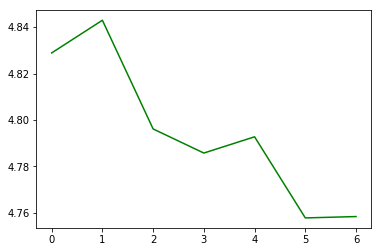

In [11]:
t = range(n_splits)
plt.plot(t, errs, 'g', label='Prediction')
plt.show()

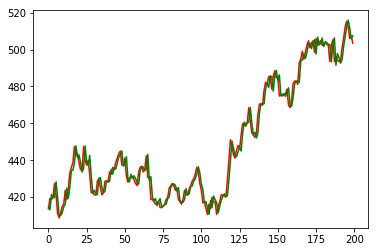

In [12]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, regressors[0].predict(X_test), 'g', label='Prediction')
plt.show()

In [13]:
regressors[0].coef_

array([[ 0.00651374,  0.02583535,  0.02437921, -0.01885374,  0.01484998,
        -0.13749529,  0.17799584, -0.05733284, -0.08866287,  1.05339711]])

In [14]:
from sklearn.linear_model import Ridge 

def ridge(X_train, X_test, y_train, y_test):
    reg = Ridge()
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    #print("Pred: ", pred[:5])
    #print("Test: ", y_test[:5])
    print_metrics(y_test.values, pred)
    return rmse(y_test.values, pred), reg

In [15]:
enregs=[]
for X_train, X_test, y_train, y_test in cv_sets:
    enregs.append(ridge(X_train,X_test,y_train,y_test)[1])
    

RMSE 4.869521
Root Mean Squared Percentage Error 1.089557
Mean Absolute Error: 3.762083
Explained Variance Score: 0.974412
Mean Squared Error: 23.712231
R2 score: 0.973938

RMSE 4.890978
Root Mean Squared Percentage Error 1.093220
Mean Absolute Error: 3.795264
Explained Variance Score: 0.974795
Mean Squared Error: 23.921670
R2 score: 0.974257

RMSE 4.858452
Root Mean Squared Percentage Error 1.083374
Mean Absolute Error: 3.776117
Explained Variance Score: 0.975816
Mean Squared Error: 23.604551
R2 score: 0.975095

RMSE 4.848795
Root Mean Squared Percentage Error 1.080062
Mean Absolute Error: 3.765104
Explained Variance Score: 0.976303
Mean Squared Error: 23.510815
R2 score: 0.975538

RMSE 4.859070
Root Mean Squared Percentage Error 1.080956
Mean Absolute Error: 3.775815
Explained Variance Score: 0.976423
Mean Squared Error: 23.610558
R2 score: 0.975603

RMSE 4.818871
Root Mean Squared Percentage Error 1.070383
Mean Absolute Error: 3.738977
Explained Variance Score: 0.976954
Mean Squared

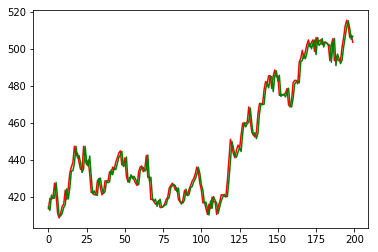

In [16]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, enregs[1].predict(X_test), 'g', label='Prediction')
plt.show()

In [17]:
enregs[1].coef_

array([[ 0.00425511,  0.02326752,  0.02887893, -0.0211307 ,  0.01547421,
        -0.13709511,  0.17784227, -0.05709013, -0.08828309,  1.0498419 ]])

In [18]:
from sklearn.svm import LinearSVR
def svr(X_train, X_test, y_train, y_test):
    # Classify and predict
    reg = LinearSVR()
    reg.fit(X_train, y_train.values.ravel())
    pred = reg.predict(X_test)

    #print("Pred: ", pred[:5])
    #print("Test: ", y_test[:5])

    print_metrics(y_test.values.ravel(), pred)
    return rmse(y_test.values.ravel(), pred), reg

In [19]:
svrs=[]
for X_train, X_test, y_train, y_test in cv_sets: 
    svrs.append(svr(X_train,X_test,y_train,y_test)[1])

RMSE 5.432707
Root Mean Squared Percentage Error 1.227269
Mean Absolute Error: 4.239735
Explained Variance Score: 0.974361
Mean Squared Error: 29.514301
R2 score: 0.967561

RMSE 14.741966
Root Mean Squared Percentage Error 3.275217
Mean Absolute Error: 13.895995
Explained Variance Score: 0.973929
Mean Squared Error: 217.325568
R2 score: 0.766131

RMSE 6.219995
Root Mean Squared Percentage Error 1.404187
Mean Absolute Error: 5.038255
Explained Variance Score: 0.975781
Mean Squared Error: 38.688344
R2 score: 0.959180

RMSE 6.794071
Root Mean Squared Percentage Error 1.529264
Mean Absolute Error: 5.610784
Explained Variance Score: 0.976166
Mean Squared Error: 46.159394
R2 score: 0.951973

RMSE 5.790190
Root Mean Squared Percentage Error 1.299720
Mean Absolute Error: 4.600482
Explained Variance Score: 0.976280
Mean Squared Error: 33.526295
R2 score: 0.965357

RMSE 5.275683
Root Mean Squared Percentage Error 1.182737
Mean Absolute Error: 4.093058
Explained Variance Score: 0.976877
Mean Squa

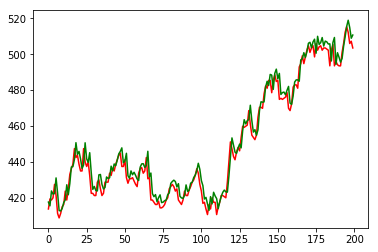

In [20]:
t = range(len(y_test))
plt.plot(t, y_test, 'r', label='Actual')
plt.plot(t, svrs[0].predict(X_test), 'g', label='Prediction')
plt.show()

In [21]:
last = np.array([310.5,312.5, 313.5,316.200012,316.299988,314.799988,316.100006,320.5,308.79998,308.700012]).reshape(1,-1)
pred = regressor.predict(last)
pred

array([[308.91784892]])

In [22]:
last = np.array([316.200012, 316.299988,314.799988,316.100006,320.5,308.799988,313.700012,310.80,318.30,324.00]).reshape(1,-1)
pred = regressor.predict(last)
pred


array([[325.38528696]])

In [23]:
from sklearn.externals import joblib
joblib.dump(regressors[0], 'prediction_model.pkl') 

['prediction_model.pkl']